In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install tensorflow_text
!pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.4 MB/s eta 0:00:00


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_4230/10159931.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
import string

2024-02-12 09:48:51.009977: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 09:48:51.191974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 09:48:51.192016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 09:48:51.204880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 09:48:51.236789: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 09:48:51.237216: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
def filter_and_replace_punctuations(text):
    # Create a translation table to replace punctuations with spaces
    translation_table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

    # Use translate method
    filtered_text = text.translate(translation_table)

    # Alternatively, you can use the replace method
    # filtered_text = text.replace(string.punctuation, ' ' * len(string.punctuation))

    return filtered_text

In [4]:
df_phishing_links = pd.read_csv("datasets/phishing_site_urls.csv")

In [5]:
df_phishing_links['URL'] = df_phishing_links['URL'].apply(lambda x: filter_and_replace_punctuations(x))

In [6]:
df_phishing_links['Label'].replace('bad',1,inplace=True)

/tmp/ipykernel_4230/566925143.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_phishing_links['Label'].replace('bad',1,inplace=True)


In [7]:
df_phishing_links.replace('good',0,inplace=True)

/tmp/ipykernel_4230/1310058204.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_phishing_links.replace('good',0,inplace=True)


In [8]:
df_phishing_links['Label'].value_counts()

Label
0    392924
1    156422
Name: count, dtype: int64

In [9]:
df_phishing_links[df_phishing_links['Label'] ==0]

,URL,Label
18231,esxcc com js index htm us battle net noghn en ...,0
18232,wwweira¯ nvinip¿ncH¯wVö ÆåyDaHðû ÏyEùuË\nÓ6...,0
18233,www institutocgr coo web media syqvem dk óij...,0
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸ à Í,0
18236,ruta89fm com images AS Vies 1i75cf7b16vc Fd16...,0
...,...,...
483590,youthleaguesusa com potomacsoccer 2011 Tournam...,0
483591,zip codes com,0
483592,owens edu news releases p 2052,0
483593,1 safesecureweb com egale index asp item 1173,0


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_phishing_links['URL'], df_phishing_links['Label'], test_size=0.4, random_state=42)

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(329607,) (219739,) (329607,) (219739,)


In [12]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("bert_models/bert-preprocessor")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("bert_models/tinybert",trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [13]:
fii = tf.keras.layers.Dropout(0.2,name='dropout')(pooled_output)
# fii=tf.keras.layers.Dense(64,activation='relu',name='hidden')(fii)
fii=tf.keras.layers.Dense(32,activation='relu',name='hiddenn')(fii)
fii=tf.keras.layers.Dense(8,activation='relu',name='hiddennn')(fii)
fii=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(fii)

In [14]:
model=tf.keras.Model(inputs=[text_input],outputs=[fii])


In [15]:
# run this for getting the last trained checkpoint
latest = tf.train.latest_checkpoint("checkpoints/run")
model.load_weights(latest)

In [120]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints/checkpoint_phish/run/chkpt.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

In [121]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5,callbacks=[cp_callback],batch_size=64,workers=8, use_multiprocessing=True)

Epoch 1/5
5150/5151 [============================>.] - ETA: 0s - loss: 0.5345 - accuracy: 0.7517
Epoch 1: saving model to run/chkpt.ckpt
5151/5151 [==============================] - 1497s 290ms/step - loss: 0.5345 - accuracy: 0.7517
Epoch 2/5
5150/5151 [============================>.] - ETA: 0s - loss: 0.5218 - accuracy: 0.7582
Epoch 2: saving model to run/chkpt.ckpt
5151/5151 [==============================] - 1490s 289ms/step - loss: 0.5218 - accuracy: 0.7582
Epoch 3/5
5150/5151 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.7611
Epoch 3: saving model to run/chkpt.ckpt
5151/5151 [==============================] - 1633s 317ms/step - loss: 0.5149 - accuracy: 0.7611
Epoch 4/5
5150/5151 [============================>.] - ETA: 0s - loss: 0.5117 - accuracy: 0.7626
Epoch 4: saving model to run/chkpt.ckpt
5151/5151 [==============================] - 1618s 314ms/step - loss: 0.5117 - accuracy: 0.7626
Epoch 5/5
5150/5151 [============================>.] - ETA: 0s - los

In [26]:
y_predict=model.predict(X_test)
y_pred=np.where(y_predict>0.5,1,0)

6867/6867 [==============================] - 971s 141ms/step


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

classification_rep = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86    157365
           1       0.79      0.28      0.41     62374

    accuracy                           0.77    219739
   macro avg       0.78      0.63      0.64    219739
weighted avg       0.78      0.77      0.73    219739



In [28]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[152703   4662]
 [ 44929  17445]]


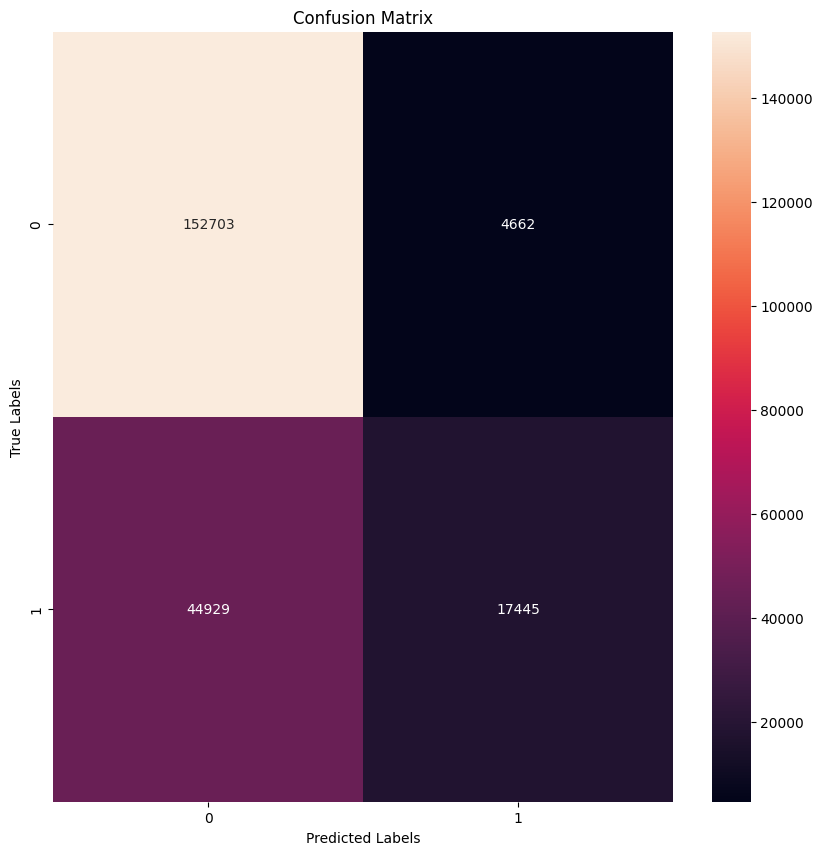

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [30]:
model.save("newphisingModel.keras")